Artificial Intelligence in Neuro-oncology
Radiogenomics applied (Hands-on) - Pyradiomics

This script shows how to perform radiomics analysis using  The Cancer Genome Atlas (TCGA) Low Grade Glioma (LGG) data (1). These scans were already skull-stripped and co-registered, and their tumor segmentation labels were produced by an automated hybrid generative-discriminative method. TCGA data can be accessed from [here](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=24282668#24282668197861a846e445a795694ff2a50eb66c) (2). 

Molecular biomarkers of brain tumors were integrated into typing, subtyping and grading of major groups. Isocitrate dehydrogenase (IDH) mutation and 1p19q codeletion biomarkers have been identified as significant predictors for therapy and prognosis in LGG. The current tutorial aims to construct a machine learning-based model for identifying molecular subtypes of LGG as:

   **i) IDH-mutant and 1p19q non-codeleted astrocytoma ('0' in csv file)**
  
  **ii) IDH-mutant and 1p19q codeleted oligodendroglioma ('1' in csv file)**
        
A total of 49 LGG (Grade 2/3 (denoted in csv file as 0/1 respectively)) were included in this example. The sum of 1820 radiomic features were extracted from T2-weigted MRI using PyRadiomics platform (3).  Clinical information were simplified for better understanding and appended to radiomic features file (t2_tcga_features.csv).

The main workflow of this script:

1. Feature extraction using PyRadiomics
2. Loading data
3. Feature normalization 
4. Feature selection 
5. Model training
6. Statistical analysis 
7. Kaplan-Meier and Cox proportional hazards survival analyses.

References: 

1. The Cancer Imaging Archive. DOI:  10.7937/K9/TCIA.2017.GJQ7R0EF.In this example, we differentiate oligodendrogliomas from astrocytomas. 
2. Bakas S, Akbari H, Sotiras A, Bilello M, Rozycki M, Kirby J, Freymann J, Farahani K, Davatzikos C. (2017) Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-LGG collection [Data Set]. 
3. Joost J M van Griethuysen, Andriy Fedorov, Chintan Parmar, Ahmed Hosny, Nicole Aucoin, Vivek Narayan, Regina G H Beets-Tan, Jean-Christophe Fillion-Robin, Steve Pieper, and Hugo J W L Aerts. (2017) Computational radiomics system to decode the radiographic phenotype. Cancer Res., 77(21):e104–e107.

In [1]:
# Loading required libraries
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor

# Feature extraction using PyRadiomics 

'Pre-operative_TCGA_LGG_NifTI_and_Segmentations' data comprised of pretreatment scans and the 'GlistrBoost_ManuallyCorrected.nii' segmentations of each patients. These segmentations include three glioma sub-regions (enhancing part of tumor core, non-enhancing part of tumor core, and edema). We generated 'merged.nii' from the union of these sub-regions as whole tumor and used for computation of radiomic features.

'Gliom_1mm.yaml' is an example parameter file for customizing the feature extraction (e.g., resampling, applying filters to images, or specifying which features to be calculated). 

'tcga_t2_dir.csv' is a batch processing file where each row provides the patient ID, and corresponding image and mask locations. Additional columns are patients' clinical information (e.g. age, gender, survival data ,etc.).

To run the tutorial, you will need 't2_tcga_features.csv'. This is the file with the PyRadiomics output appended to 'tcga_t2_dir.csv', and also can be generated using the following cell.

In [3]:
#Defining path, params 
path = r'/Users/esra/Desktop/GliMR_Radiomics'
params = os.path.join(path, 'Gliom_1mm.yaml')
# Input csv consisting file locations and outputcsv for computed features
inputCSV = os.path.join(path, 'tcga_t2_dir.csv')
outputCSV = os.path.join(path, 't2_tcga_features.csv')

try:
    # Use pandas to read and transpose ('.T') the input data
    # The transposition is needed so that each column represents one test case. This is easier for iteration over
    # the input cases
    flists = pd.read_csv(inputCSV, sep=';').T
except Exception:
    print('CSV READ FAILED')
    exit(-1)

extractor = featureextractor.RadiomicsFeatureExtractor(params)

results = pd.DataFrame()

for entry in flists:  # Loop over all columns (i.e. the test cases)
  imageFilepath = flists[entry]['Image']
  maskFilepath = flists[entry]['Mask']
  label = flists[entry].get('Label', None)

  if str(label).isdigit():
    label = int(label)
  else:
    label = None

  if (imageFilepath is not None) and (maskFilepath is not None):
    featureVector = flists[entry]  # This is a pandas Series
    featureVector['Image'] = os.path.basename(imageFilepath)
    featureVector['Mask'] = os.path.basename(maskFilepath)

    try:
      # PyRadiomics returns the result as an ordered dictionary, which can be easily converted to a pandas Series
      # The keys in the dictionary will be used as the index (labels for the rows), with the values of the features
      # as the values in the rows.
      result = pd.Series(extractor.execute(imageFilepath, maskFilepath, label))
      featureVector = featureVector.append(result)
    except Exception:
      print('FEATURE EXTRACTION FAILED:')

    # To add the calculated features for this case to our data frame, the series must have a name (which will be the
    # name of the column.
    featureVector.name = entry
    # By specifying an 'outer' join, all calculated features are added to the data frame, including those not
    # calculated for previous cases. This also ensures we don't end up with an empty frame, as for the first patient
    # it is 'joined' with the empty data frame.
    results = results.join(featureVector, how='outer')  # If feature extraction failed, results will be all NaN


#Saving computed features
# .T transposes the data frame, so that each line will represent one patient, with the extracted features as columns
results.T.to_csv(outputCSV,sep=';', index=False, na_rep='NaN')

# Loading data

In [3]:
##Loading extracted radiomics features of T2 weigted MRI
t2 = pd.read_csv(r'/Users/esra/Desktop/Radiogenomics_EsraSumer/t2_tcga_features.csv',sep=';') 
y = t2['IDH_co_del'] #selecting target column

target_count = y.value_counts(normalize=False)
#Counts of astrocytoma (0) and oligodendrogliomas (1)
print('Class astro:', target_count[0])
print('Class oligo:', target_count[1])

feature_names = t2.columns;
index = feature_names.get_loc('original_shape_Elongation')
X = t2.iloc[:,index:] # selecting radiomics features 

X.shape # Dataframe of [patients, radiomic features]


Class astro: 37
Class oligo: 12


(49, 1820)

# Feature Selection

In [4]:
# Feature selection using low variance
# Radiomics generate large number of features/patient. Feature selection
# is a vital step. 
# Variance thresholding removes the features smaller than 0.05 variance

from sklearn.feature_selection import VarianceThreshold

feat_labels = X.columns
v_threshold = VarianceThreshold(threshold=(0.05))
X = v_threshold.fit_transform(X)
feat_labels = feat_labels[v_threshold.get_support()]
X = pd.DataFrame(data=X,columns=feat_labels)
X.shape


(49, 1112)

(49, 68)

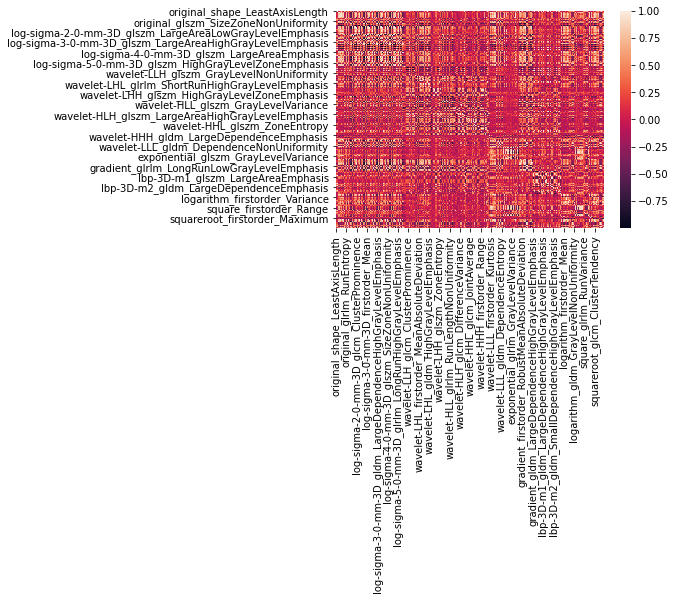

In [5]:
# Eliminating collinear features
# The correlation coefficient between each pair of features was calculated 
# to eliminate redundancy. For feature pairs with correlation coefficient >0.75 was removed. 

import matplotlib.pyplot as plt
import seaborn as sns

corr = X.corr()
sns.heatmap(corr)

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.75 or corr.iloc[i,j] <= -0.75:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X = X[selected_columns]
feat_labels = X.columns
X.shape


# Lasso feature selection and model training & evaluation

In [6]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Create a dataframe for feature selection frequency
feat_counts= pd.DataFrame(data=np.zeros((feat_labels.size,1),dtype=int),
                           columns=['counts'],
                           index=feat_labels,
                           dtype=np.integer)

# Create a dataframe for model performence measuremetns over each iteration on the test data with different
# seed values

rows = [
    'SVC', 
    'kNN',
    'LogisticRegression',
    'BaggingClassifier',
    'RandomForestClassifier',
    'DecisionTreeClassifier',
    'AdaBoostClassifier',
]

results_Accuracy = pd.DataFrame(data=None,columns=[rows],index=range(100),dtype=np.float64)
results_Sensitivity = pd.DataFrame(data=None,columns=[rows],index=range(100),dtype=np.float64)
results_Specificity = pd.DataFrame(data=None,columns=[rows],index=range(100),dtype=np.float64)

#This process was repeated 100 times with different seed values to have more generalizable results

for i in tqdm(range(100)):
    seed = i

    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        stratify=y,
                                                        test_size=0.20,
                                                        random_state=seed)
    
    #Feature scaling using standard scaling for standardization, 
    #so that features of different orders of magnitude could be reasonably compared.
    std_scale = StandardScaler()
    X_train_scaled = std_scale.fit_transform(X_train)
    X_test_scaled = std_scale.transform(X_test)

    #Oversampling for imbalance dataset (optional)
    #oversampling = SMOTE(random_state=seed)
    # oversampling = ADASYN(random_state=seed)
    # X_train_scaled,y_train = oversampling.fit_resample(X_train_scaled,y_train)
        
    #(LASSO) feature selection method was applied to the training set to search 
    #the optimal predictive features
    clf = LassoCV(cv=5,max_iter=100000)
    sfm = SelectFromModel(clf, threshold="1.25*mean")
    sfm.fit(X_train_scaled, y_train)
    X_important_train = sfm.transform(X_train_scaled)
    X_important_test = sfm.transform(X_test_scaled)
    
    #counting feature selection frequency
    for feature_list_index in sfm.get_support(indices=True):
        feat_counts.counts[feature_list_index] += 1
        
    models = [
        SVC(gamma='auto',random_state=seed),
        KNeighborsClassifier(),
        LogisticRegression(solver='lbfgs',C=10, random_state=seed),
        BaggingClassifier(random_state=seed),
        RandomForestClassifier(n_estimators= 300,random_state=seed),
        DecisionTreeClassifier(random_state=seed),
        AdaBoostClassifier(random_state=seed),
    ]
    
    #running classification models for differentiation of astro vs. oligo
    for j,model in enumerate(models):
        model.fit(X_important_train,y_train)

        y_pred_train = model.predict(X_important_train)
        y_pred = model.predict(X_important_test)
        
        #getting performance measurements 
        confusion_matrix_test = confusion_matrix(y_test, y_pred)

        TN = confusion_matrix_test[0][0]
        FN = confusion_matrix_test[1][0]
        TP = confusion_matrix_test[1][1]
        FP = confusion_matrix_test[0][1]
        Sensitivity = TP / (TP+FN)
        Specificity = TN / (TN+FP)

        acc = accuracy_score(y_test, y_pred)
        acc_train = accuracy_score(y_train, y_pred_train)
        
    # getting each model performence on test data
        results_Accuracy.loc[[i],[rows[j]]] = acc
        results_Sensitivity.loc[[i],[rows[j]]] = Sensitivity
        results_Specificity.loc[[i],[rows[j]]] = Specificity

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


In [8]:
#Printing Accuracy, Sensitivity and Specificity measurements over 100 iterations
print('\nAccuracy:\n', results_Accuracy.describe().transpose())
print('\nSensitivity:\n', results_Sensitivity.describe().transpose())
print('\nSpecificity:\n', results_Specificity.describe().transpose())


Accuracy:
                         count   mean       std  min  25%  50%  75%  max
SVC                     100.0  0.885  0.082112  0.6  0.8  0.9  0.9  1.0
kNN                     100.0  0.856  0.122532  0.5  0.8  0.9  1.0  1.0
LogisticRegression      100.0  0.874  0.108823  0.6  0.8  0.9  1.0  1.0
BaggingClassifier       100.0  0.795  0.097830  0.5  0.7  0.8  0.9  1.0
RandomForestClassifier  100.0  0.823  0.091954  0.5  0.8  0.8  0.9  1.0
DecisionTreeClassifier  100.0  0.705  0.120918  0.4  0.6  0.7  0.8  0.9
AdaBoostClassifier      100.0  0.794  0.119612  0.5  0.7  0.8  0.9  1.0

Sensitivity:
                         count   mean       std  min  25%  50%  75%  max
SVC                     100.0  0.600  0.340825  0.0  0.5  0.5  1.0  1.0
kNN                     100.0  0.675  0.336162  0.0  0.5  0.5  1.0  1.0
LogisticRegression      100.0  0.780  0.304180  0.0  0.5  1.0  1.0  1.0
BaggingClassifier       100.0  0.375  0.328564  0.0  0.0  0.5  0.5  1.0
RandomForestClassifier  100.0  0.405 

In [7]:
#The selected features from process of LASSO regression were ranked by selection frequency over 100 iterations
#The selected features with a frequency above 75% were selected for statistical analyses 
#(e.g. Mann-Whitney and survival)
feat_counts = feat_counts.sort_values("counts",ascending=False)
print(feat_counts.head(20))

                                                counts
original_glrlm_RunEntropy                          100
original_gldm_DependenceVariance                    98
wavelet-HLL_firstorder_Skewness                     95
wavelet-LHL_firstorder_Skewness                     80
original_glszm_ZoneEntropy                          73
wavelet-LLH_firstorder_Maximum                      67
wavelet-LLH_glrlm_LongRunLowGrayLevelEmphasis       55
lbp-3D-k_gldm_DependenceVariance                    54
wavelet-LLH_firstorder_Skewness                     34
wavelet-LHH_glcm_ClusterShade                       31
lbp-3D-m2_firstorder_Mean                           24
wavelet-LLH_glrlm_RunEntropy                        24
wavelet-HHL_firstorder_Skewness                     23
wavelet-LLH_firstorder_Mean                         21
log-sigma-2-0-mm-3D_gldm_DependenceVariance         17
wavelet-HHL_glcm_ClusterShade                       16
logarithm_firstorder_Kurtosis                       14
wavelet-LH

# Statistical Analysis: Mann-Whitney U Test

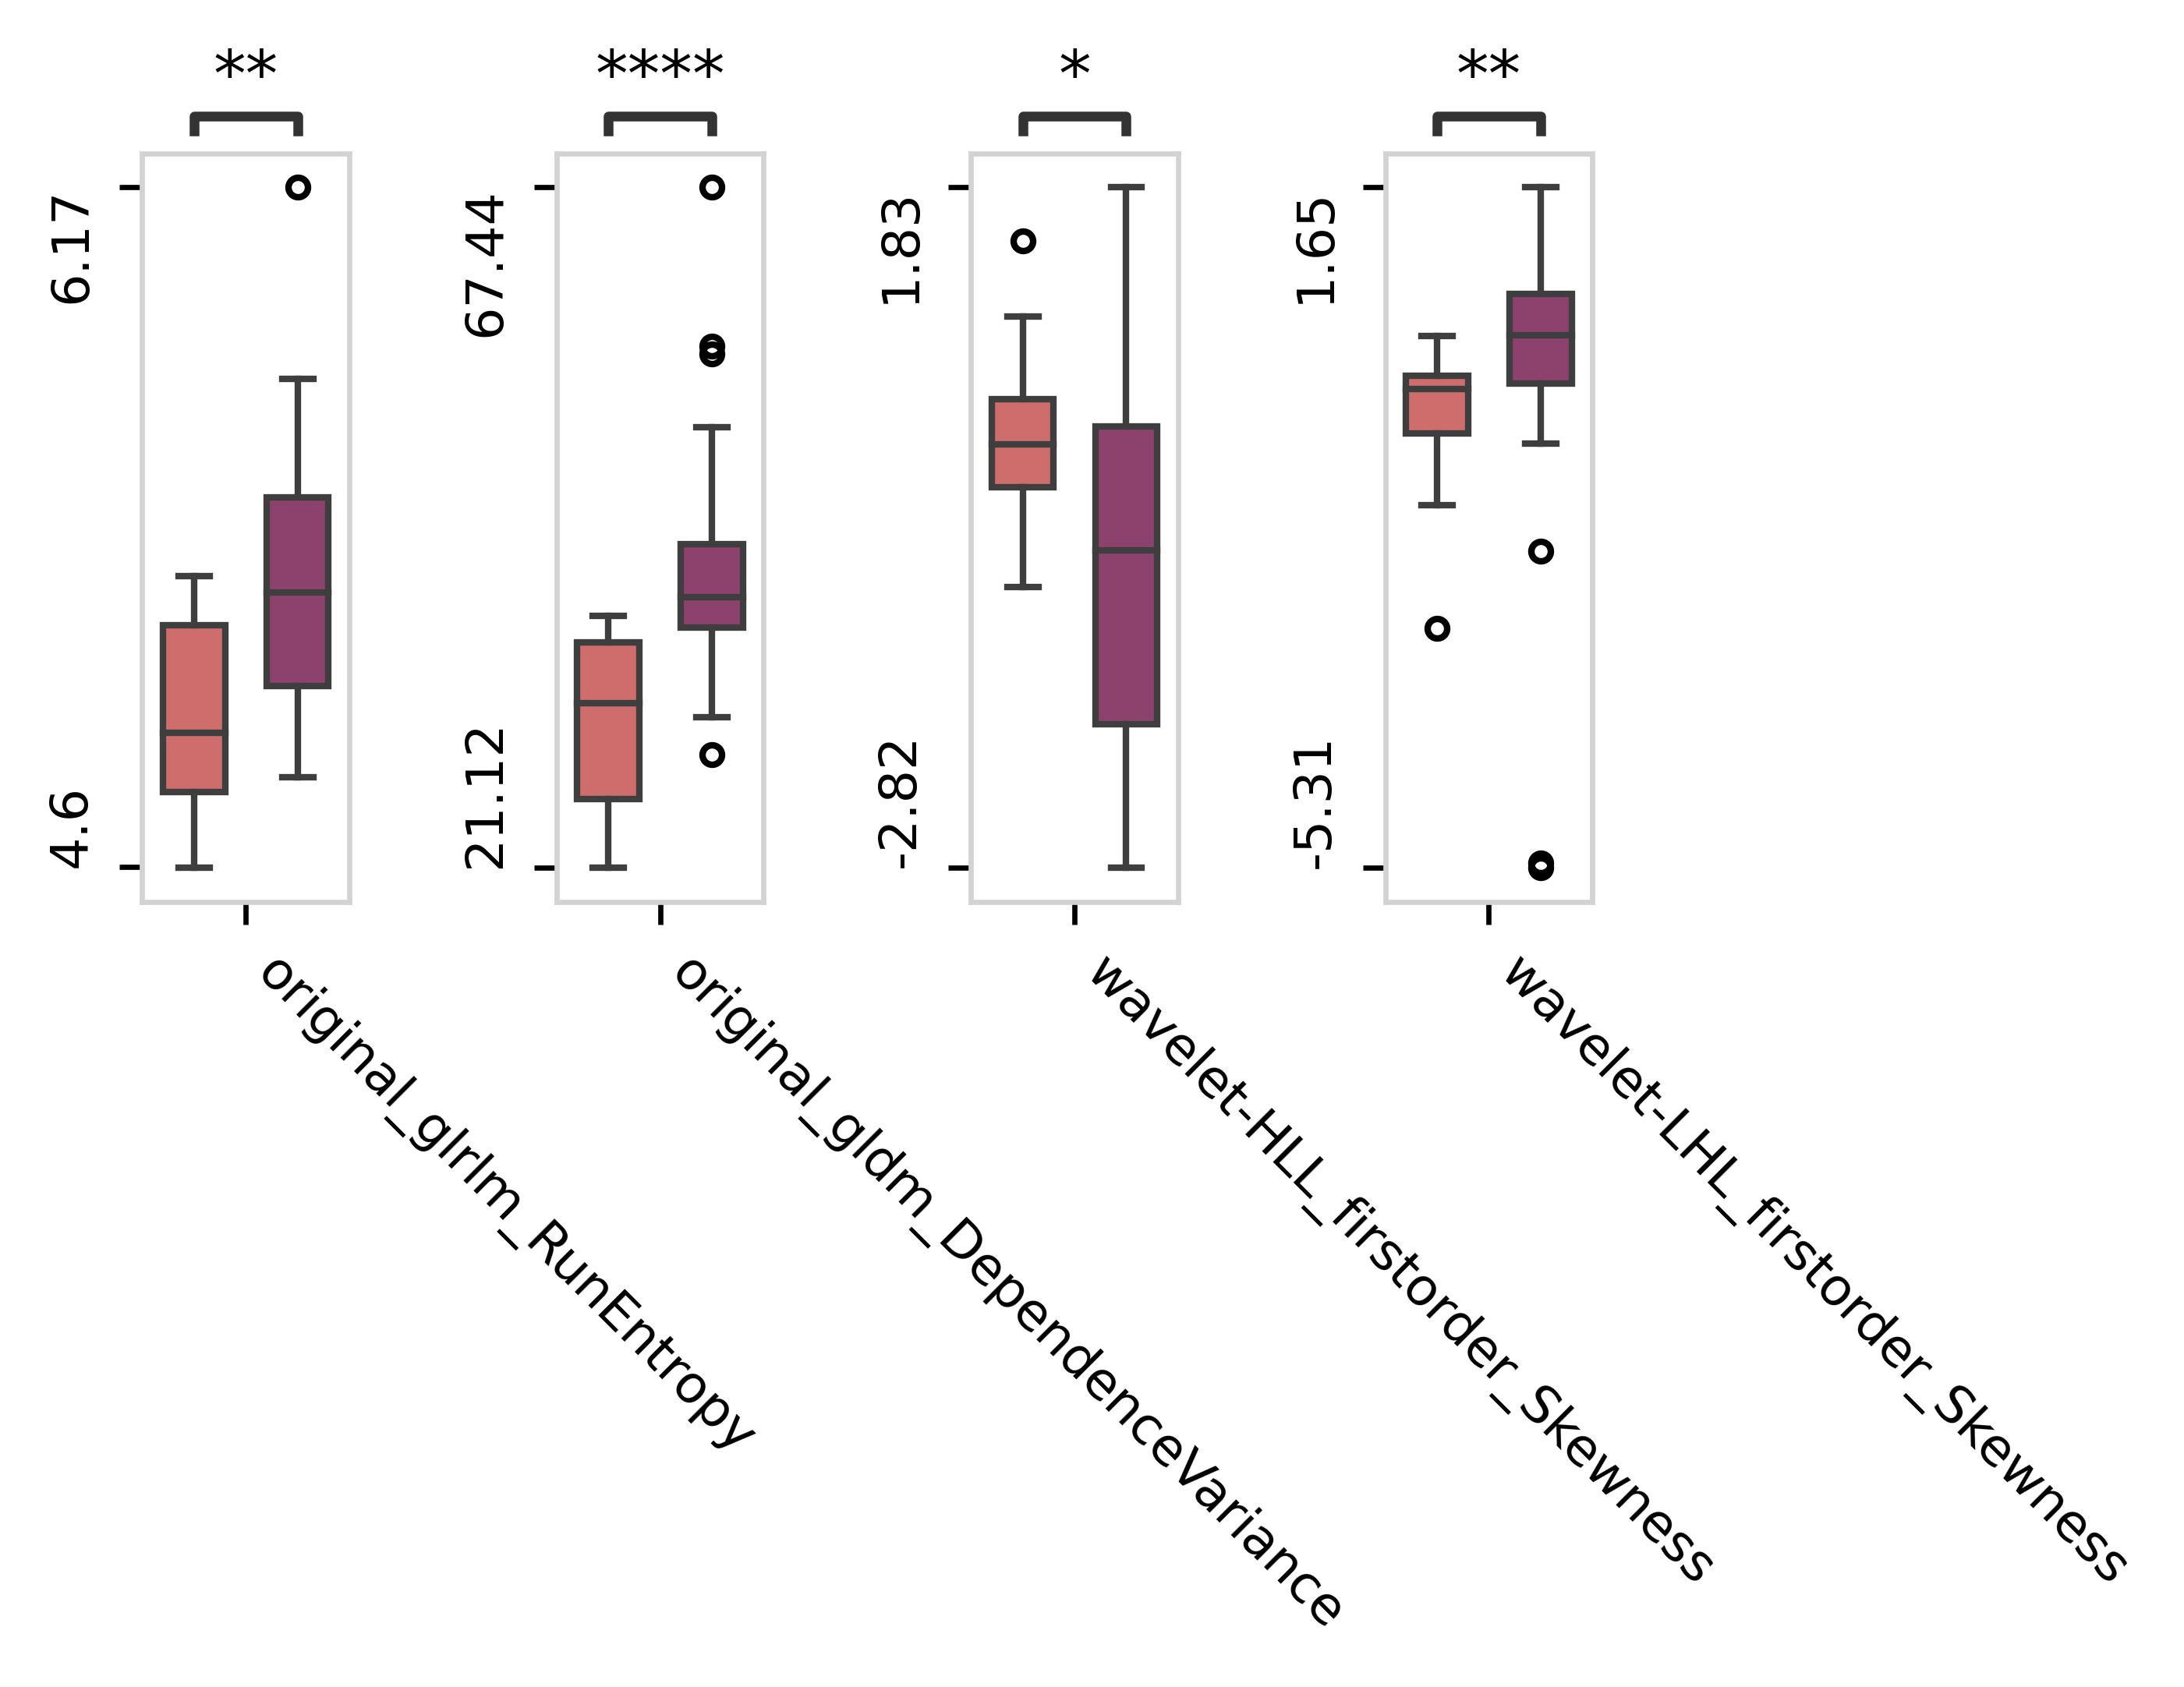

In [8]:
import scikit_posthocs as sp
import statsmodels as sm
from scipy import stats
from scipy.stats import mannwhitneyu

#Finding indices of astro and oligo subgroups
astro = np.where(y==0)[0]
oligo = np.where(y==1)[0]

##Mann-Whitney U
from statannot import add_stat_annotation

#Differences between features with selection frequency of 
#above 75% were assessed by a Mann-Whitney U test. 

X_subset = X[feat_counts.index[feat_counts.counts >= 75]]
X_subset.shape

mannwhitneyu_result= pd.DataFrame(data=None, columns=['F','p'], index=X.columns)
fig, axs = plt.subplots(1, len(X_subset.columns), figsize=(4, 2), dpi=600)

for i,feature in enumerate(X_subset.columns):
    stat, p = mannwhitneyu(X_subset[feature].iloc[oligo], X_subset[feature].iloc[astro])
    mannwhitneyu_result.loc[feature] = [stat,p]
    
    #For plotting distrubution of each feature in classes 
    data= pd.DataFrame(data={'oligo':X_subset[feature].iloc[oligo], 'astro':X_subset[feature].iloc[astro]})

    flierprops = dict(marker='o', markerfacecolor='none', markersize=3,
                      markeredgecolor='k')
    sns.boxplot(data=data, ax=axs[i], flierprops=flierprops, width=.6, linewidth=1, palette='flare')
    axs[i].set_xticks([.5])
    min_val= round(min(data.min()),2)
    max_val= round(max(data.max()),2)
    axs[i].set_yticks([min_val,max_val])
    axs[i].set_xticklabels([feature], rotation=-45, ha='left')
    axs[i].set_yticklabels(['{}'.format(min_val),'{}'.format(max_val)], rotation=90)
    xTick_objects = axs[i].xaxis.get_major_ticks()
    xTick_objects[0].label.set_fontsize(8)
    yTick_objects = axs[i].yaxis.get_major_ticks()
    yTick_objects[0].label1.set_verticalalignment('bottom')   # left align first tick
    yTick_objects[-1].label1.set_verticalalignment('top') # right align last tick
    yTick_objects[0].label.set_fontsize(8)   # left align first tick
    yTick_objects[-1].label.set_fontsize(8) # right align last tick
    axs[i].spines['bottom'].set_color('lightgray')
    axs[i].spines['top'].set_color('lightgray')
    axs[i].spines['right'].set_color('lightgray')
    axs[i].spines['left'].set_color('lightgray')
    add_stat_annotation(axs[i], data=data,
                    box_pairs=[('oligo', 'astro')], perform_stat_test=True,
                    test='Mann-Whitney',text_format='star', loc='outside', verbose=0)
plt.subplots_adjust(
    left  = 0.125, # the left side of the subplots of the figure
    right = 0.9,   # the right side of the subplots of the figure
    bottom = 0.1,  # the bottom of the subplots of the figure
    top = 0.9,     # the top of the subplots of the figure
    wspace = 1.0,  # the amount of width reserved for blank space between subplots,
                    # expressed as a fraction of the average axis width
    hspace = 0.2   # the amount of height reserved for white space between subplots,
                    # expressed as a fraction of the average axis height)
    )
#To visualize features distrubution in classses, plot bar graphs and 
#check for Mann-Whitney U test p-values. 
plt.show()

#plt.savefig('bar_IDH_codel.png',bbox_inches='tight', dpi=600)

In [9]:
# Print statistical test result of features with higher frequency.
# Frequently selected features significantly differed in astro and oligo
# subgroups.

print(mannwhitneyu_result.sort_values("p").head(4)) 

                                      F         p
original_gldm_DependenceVariance   52.0  0.000041
original_glrlm_RunEntropy          84.0  0.000695
wavelet-LHL_firstorder_Skewness   106.0  0.003623
wavelet-HLL_firstorder_Skewness   137.0  0.024731


# Kaplan Meier Survival Analysis for Oligo vs. Astro

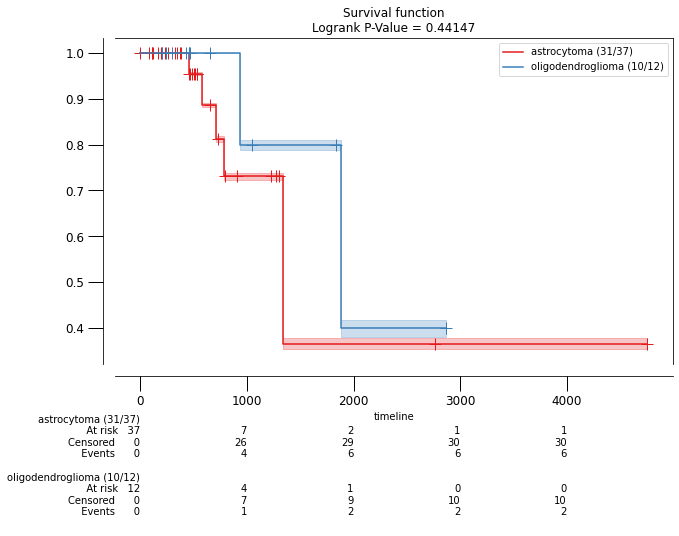

In [10]:
#To assess differences in overall survival between astro and oligo. 

import kaplanmeier as km

#adding more clinic information to covariants
data_surv_labels = ['Age','Gender','WHOGrade','IDH_co_del','death','daystolastordeath']
data_surv = t2[data_surv_labels]

data_surv = data_surv.assign(Subtype=np.where(data_surv['IDH_co_del'],'oligodendroglioma','astrocytoma'))

time_event = data_surv['daystolastordeath']
results = km.fit(time_event,data_surv['death'],data_surv['Subtype'])
km.plot(results)

# Cox Propotional Hazards Model for LGG

/Users/esra/opt/anaconda3/envs/PyRadiomics/lib/python3.8/site-packages/lifelines/utils/printer.py:117: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  columns = df.columns & utils.map_leading_space(self.columns)
/Users/esra/opt/anaconda3/envs/PyRadiomics/lib/python3.8/site-packages/lifelines/utils/printer.py:74: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  columns = summary_df.columns & self.columns
/Users/esra/opt/anaconda3/envs/PyRadiomics/lib/python3.8/site-packages/lifelines/utils/printer.py:61: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  columns = summary_df.columns &

<lifelines.CoxPHFitter: fitted with 49 total observations, 41 right-censored observations>
             duration col = 'daystolastordeath'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 49
number of events observed = 8
   partial log-likelihood = -10.49
         time fit was run = 2022-07-25 10:28:21 UTC

---
                                  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                                 
original_glrlm_RunEntropy              1.05                 0.22                 4.94 0.95
original_gldm_DependenceVariance      14.71                 0.21              1018.16 0.21
wavelet-HLL_firstorder_Skewness        0.25                 0.05                 1.20 0.08
wavelet-LHL_firstorder_Skewness        6.09                 0.90                40.99 0.06
Age                                    6.71                 1.13                39.94 0.04
Gender                                 3.07                 0.31                30.01 0.34
WHOGrade                            3992.48                 0.69             2.29e+07 0.06
---
Concordance = 0.93
Partial AIC = 34.99
log-likelihood ratio test = 18.11 on 7 df
-log2(p) of ll-ratio test = 6.44

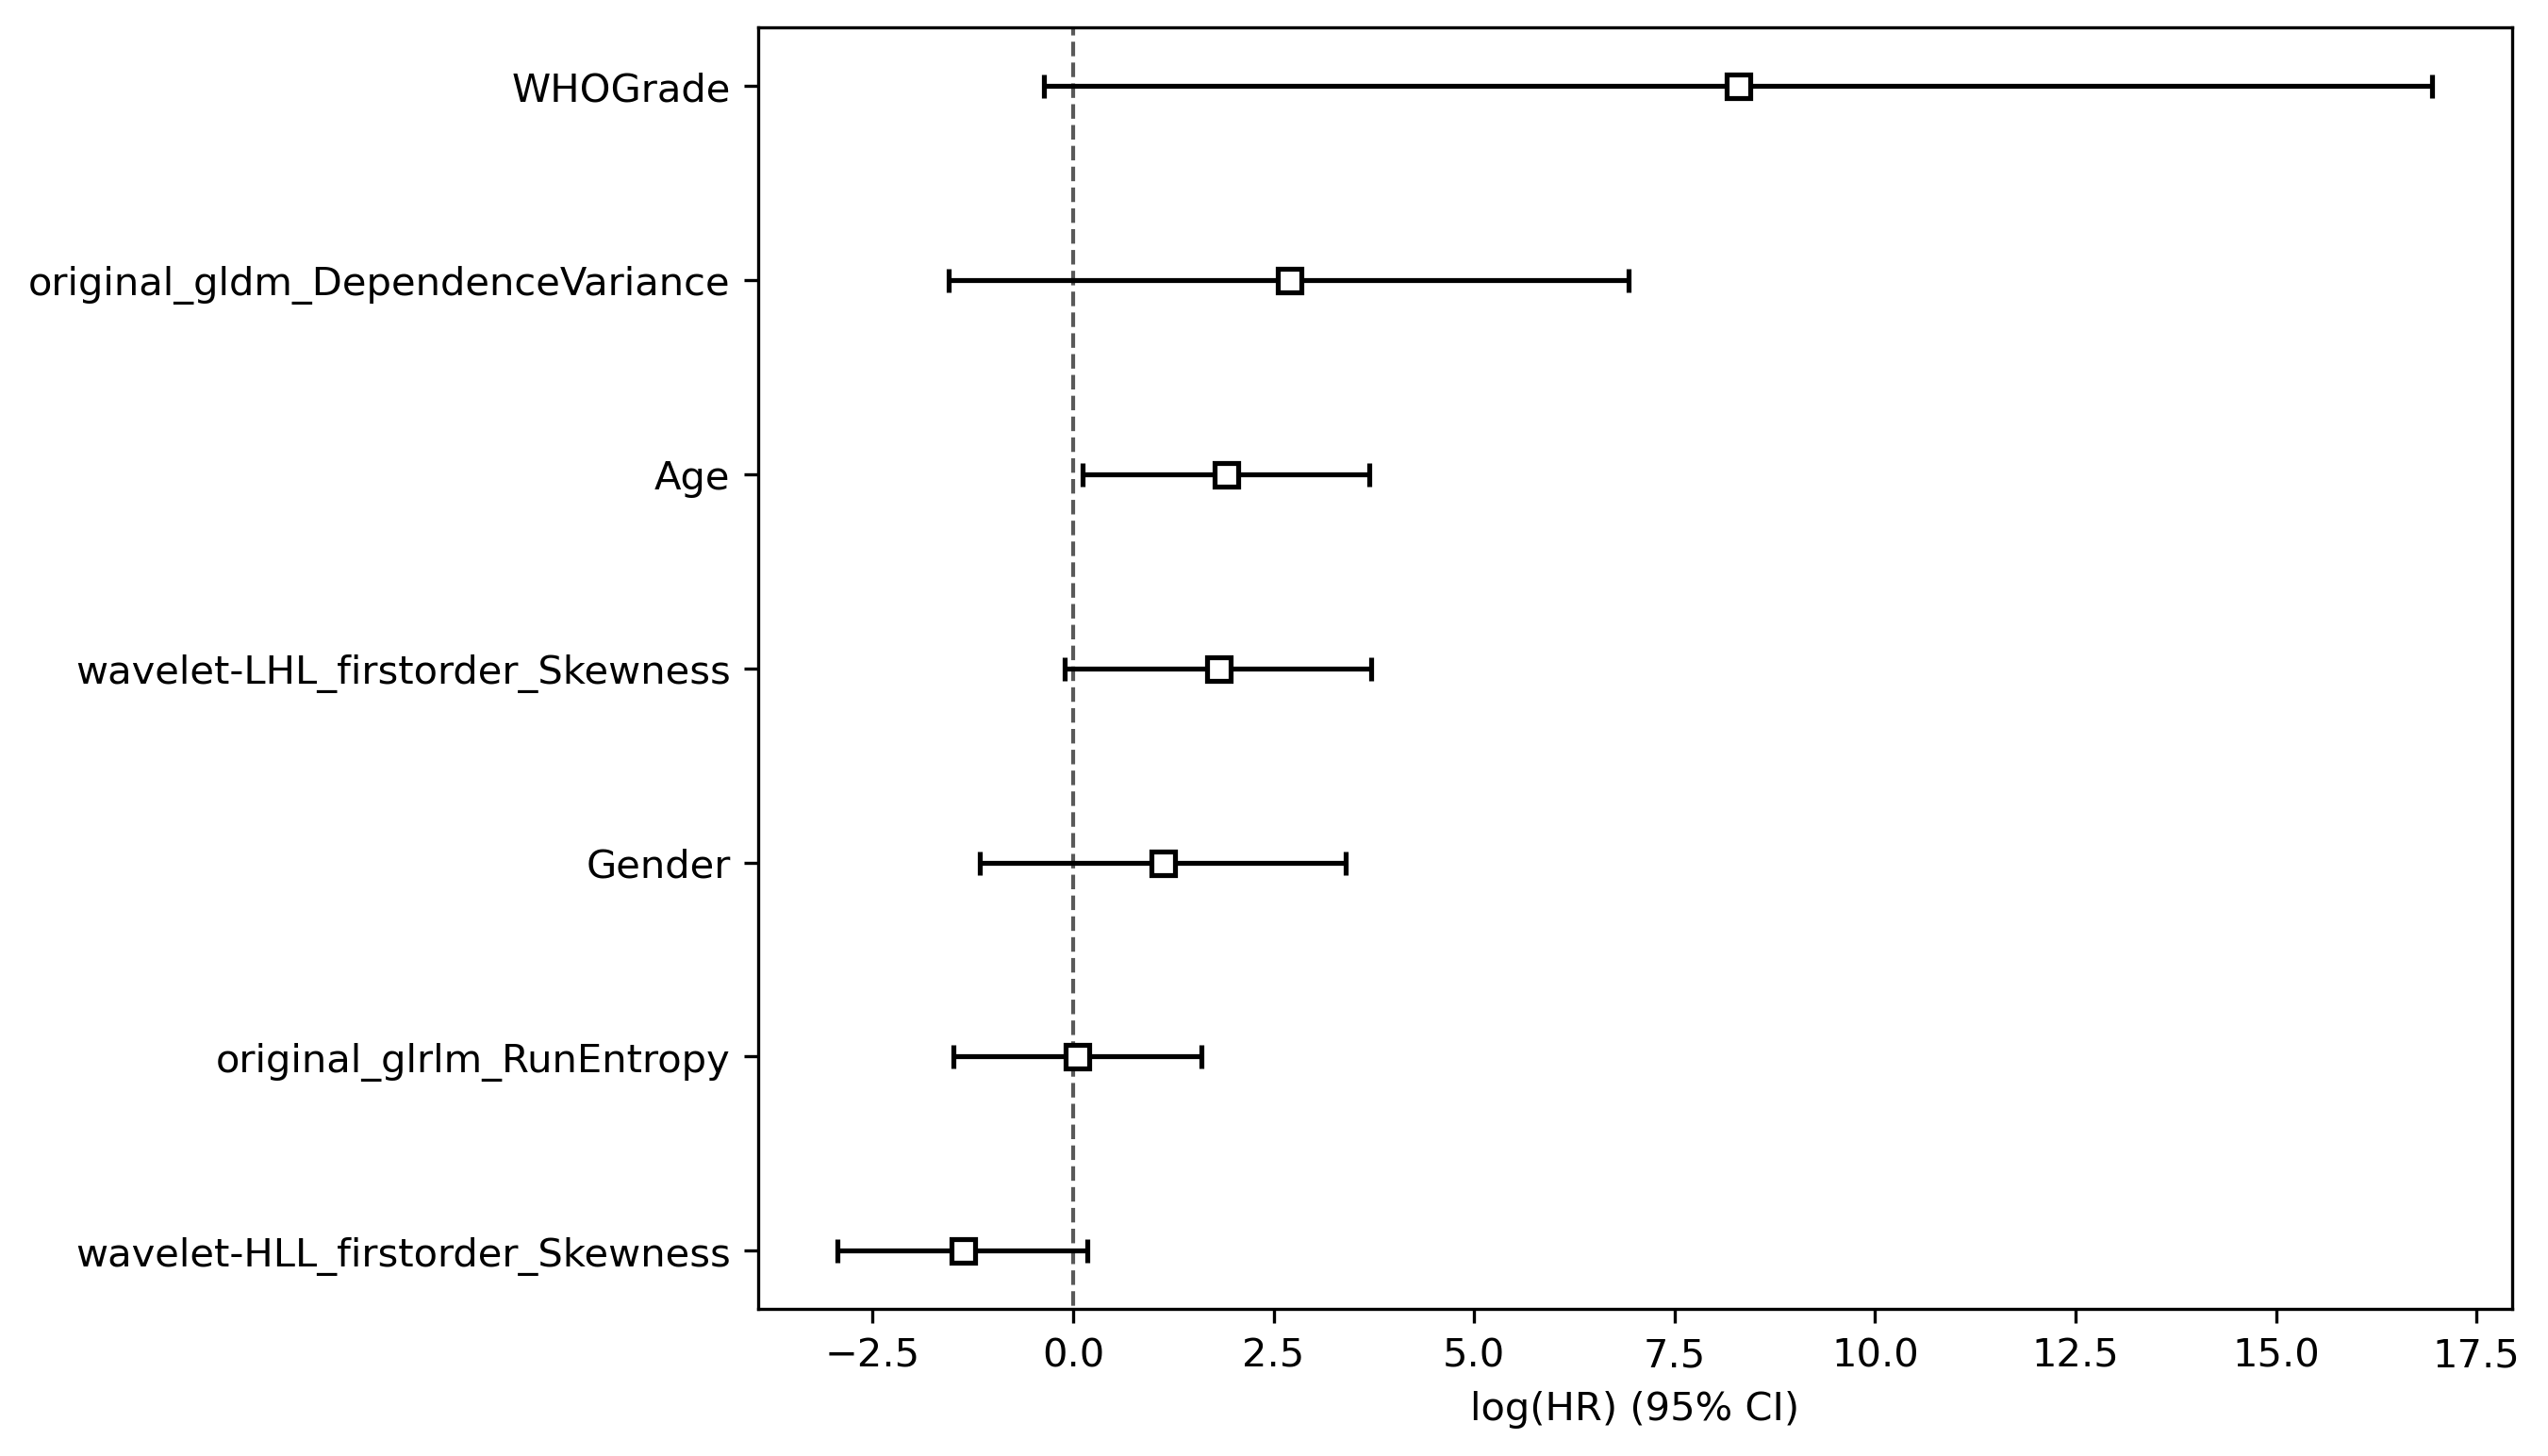

In [12]:
from lifelines import CoxPHFitter

#Cox proportional hazards model was conducted to understand prognostic value of radiomics and clinical features
#log(hazard) =0 ratio, that predictor does not affect survival. 
#log(hazard) <0 ratio, that predictor is protective (i.e., associated with improved survival) 
#log(hazard)>0 ratio, that predictor is associated with increased risk 


#scaling the selected features (frequency>%75) and age 
scaler = StandardScaler() 
cov = pd.concat([X_subset,data_surv['Age']],axis=1)

cov_scaled = cov.copy()
names = cov_scaled.columns
cov_scaled[names] = scaler.fit_transform(cov_scaled)

#adding gender, grade and survival information
cov_scaled = pd.concat([cov_scaled,data_surv[['Gender','WHOGrade','death','daystolastordeath']]],axis=1)

##Univariable Cox proportional hazards models
#for i,feature in enumerate(cov_scaled.drop(['death','daystolastordeath'],axis=1)) :
    #cph= CoxPHFitter()
    #cph.fit(cov_scaled[[feature,'daystolastordeath','death']], duration_col='daystolastordeath',
                                                               #event_col='death')
    #print(cph.print_summary(columns=["p","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%"]))

#%% Multivariable Cox proportional hazards model 
cph = CoxPHFitter()
cph.fit(cov_scaled, duration_col='daystolastordeath', event_col='death')
cph.print_summary(columns=["exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%","p"])##Hazard ratio and CI

fig,ax = plt.subplots(1, 1, figsize=(8,6), dpi=300)
cph.plot(ax=ax);
